# Forecasting Lab — Step-by-step (Google Colab ready)
**Objectives**
- Create a synthetic time series with trend, seasonality, and noise.
- Split into training and validation (split at index 1000).
- Build simple baselines: naive forecast, moving average.
- Use differencing (seasonal lag) + moving averages to handle seasonality.
- Compare methods using MAE and MSE and visualize results.

**Notes for Colab:** This notebook is written to run in Google Colab or any Jupyter environment. If a dependency is missing in Colab, run the `pip install` cells indicated below.

In [2]:
# Step 0 — (Optional) Install packages if you're in a fresh Colab runtime.
# In Google Colab you can uncomment and run the following lines if needed:
# !pip install statsmodels
#
# The core libraries used below (numpy, pandas, matplotlib) are usually preinstalled
# in Colab. The statsmodels package is used only if you want to plot ACF/PACF later.


In [3]:
# Step 1 — Setup imports and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a random seed to make the synthetic data reproducible
np.random.seed(42)

def generate_series(time, slope=0.05, amplitude=40, noise_level=5, period=365):
    """Create a synthetic time series:
    - baseline offset (50)
    - linear trend (slope * time)
    - seasonal component (sinusoid with given amplitude and period)
    - Gaussian noise (noise_level)
    Returns an array of the same length as `time`.
    """
    trend = slope * time
    seasonality = amplitude * np.sin(2 * np.pi * time / period)
    noise = np.random.randn(len(time)) * noise_level
    return 50 + trend + seasonality + noise

# Error metrics used throughout
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


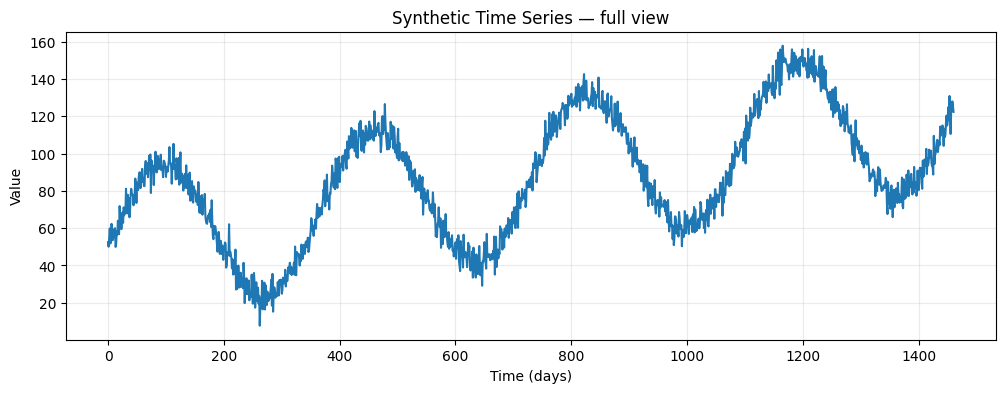

In [4]:
# Step 2 — Generate the synthetic time series and inspect it
time = np.arange(4 * 365 + 1)  # roughly 4 years of daily data
series = generate_series(time)

# Plot the full series
plt.figure(figsize=(12, 4))
plt.plot(time, series)
plt.title('Synthetic Time Series — full view')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.grid(alpha=0.25)
plt.show()

# Explanation:
# - X axis: time in days. Each tick ~ 1 day.
# - Y axis: the simulated measurement.
# - Look for three main patterns:
#   1) Trend: a gentle upward slope due to the linear term.
#   2) Seasonality: repeating waves with period ~365 days (one-year cycle).
#   3) Noise: small rapid fluctuations around the trend+seasonality.


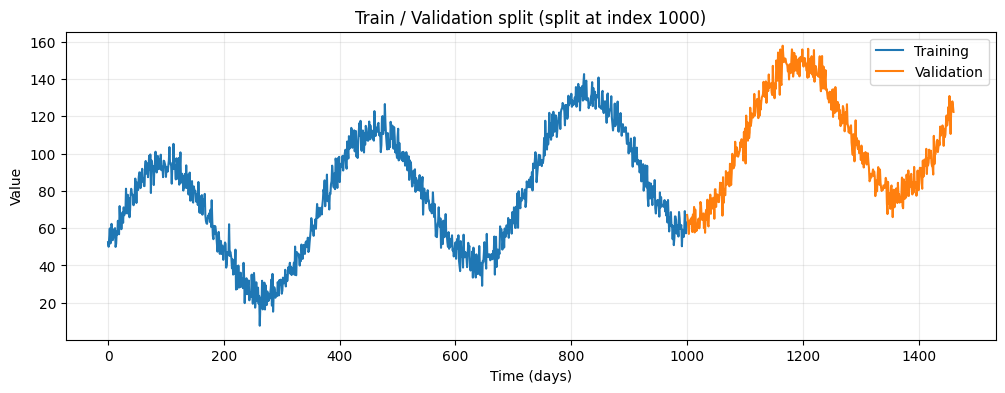

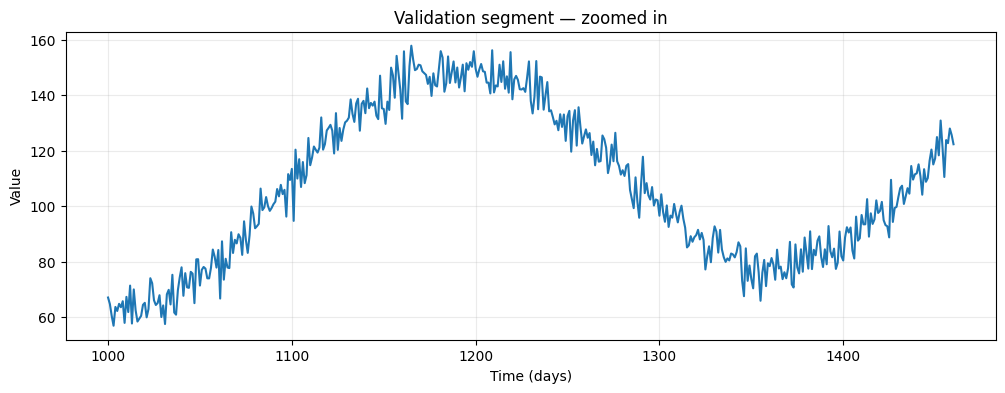

In [5]:
# Step 3 — Train/Validation split and a zoomed-in look
split_time = 1000
time_train, series_train = time[:split_time], series[:split_time]
time_valid, series_valid = time[split_time:], series[split_time:]

# Plot training and validation on the same plot
plt.figure(figsize=(12, 4))
plt.plot(time_train, series_train, label='Training')
plt.plot(time_valid, series_valid, label='Validation')
plt.title('Train / Validation split (split at index {})'.format(split_time))
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# Zoom-in view on the validation window (to see seasonal pattern in closer detail)
plt.figure(figsize=(12, 4))
plt.plot(time_valid, series_valid)
plt.title('Validation segment — zoomed in')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.grid(alpha=0.25)
plt.show()

# How to read these:
# - The first plot shows the full train and validation sets in context.
# - The zoomed-in plot helps you see short-term fluctuations and how seasonality
#   repeats across the validation window. The x-axis values are larger (later dates),
#   so the visual slope/shape can look different but the underlying pattern is similar.


In [ ]:
# Step 4 — Naive forecast (baseline)
# Rule: predict y_{t} = y_{t-1}
naive_forecast = series[split_time - 1:-1]  # aligns with validation times

print('Naive forecast lengths — validation:', len(series_valid), 'forecast:', len(naive_forecast))
print('Naive MAE:', mae(series_valid, naive_forecast))
print('Naive MSE:', mse(series_valid, naive_forecast))

# Plot naive forecast vs actual validation
plt.figure(figsize=(12, 4))
plt.plot(time_valid, series_valid, label='Validation (actual)')
plt.plot(time_valid, naive_forecast, label='Naive forecast (y_{t} = y_{t-1})')
plt.title('Naive forecast vs Actual')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# How to read this plot:
# - The naive forecast is simply a "one-step-lag" copy of the series.
# - Where the true series is smoothly increasing, the naive forecast will lag behind by 1 day.
# - If the series has high noise, naive forecasts may still be strong because many series
#   are highly autocorrelated (today is similar to yesterday).


In [ ]:
# Step 5 — Simple moving average forecast (window = 30)
window = 30

# For a forecast at time t we take mean of values at times [t-window, ..., t-1]
def moving_average_forecast(series, window, start_index):
    N = len(series)
    preds = []
    for t in range(start_index, N):
        start = max(0, t - window)
        preds.append(np.mean(series[start:t]))
    return np.array(preds)

ma_forecast = moving_average_forecast(series, window=window, start_index=split_time)

print('Moving average MAE:', mae(series_valid, ma_forecast))
print('Moving average MSE:', mse(series_valid, ma_forecast))

# Plot MA forecast
plt.figure(figsize=(12, 4))
plt.plot(time_valid, series_valid, label='Validation (actual)')
plt.plot(time_valid, ma_forecast, label=f'MA forecast (window={window})')
plt.title('Moving Average Forecast vs Actual')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# How to read the MA plot:
# - MA smooths short-term noise by averaging recent points.
# - If the series contains seasonality larger than the window, MA can be biased.
# - Notice if the MA line is smoother but systematically off when seasonal swings occur.


In [ ]:
# Step 6 — Remove seasonality by differencing with a seasonal lag
lag = 365

# Build a full-length differenced array aligned to original indices (nan for first `lag` entries)
diff_full = np.full_like(series, fill_value=np.nan)
for t in range(lag, len(series)):
    diff_full[t] = series[t] - series[t - lag]

# Plot the differenced series (from index = lag onward)
plt.figure(figsize=(12, 4))
plt.plot(time[lag:], diff_full[lag:])
plt.title(f'Differenced series (y_t - y_(t-{lag})) — seasonal component removed')
plt.xlabel('Time (days)')
plt.ylabel('Differenced Value')
plt.grid(alpha=0.25)
plt.show()

# How to read the differenced plot:
# - Differencing removes repeating seasonal swings. If seasonality was dominant,
#   the differenced plot should look more stationary (no clear repeating waveform).
# - What remains is largely trend + noise (and any non-seasonal structure).


In [ ]:
# Step 7 — Moving average on differenced series and add back seasonal component
diff_ma_window = 50
N = len(series)
diff_ma_forecast = []

# For each validation time t, compute moving average of the most recent diffs
# then add back the series value from t - lag (historic seasonal value)
for t in range(split_time, N):
    # Only consider diff entries that exist (i.e., indices >= lag)
    start_idx = max(lag, t - diff_ma_window)
    diff_vals = diff_full[start_idx:t]  # t is exclusive; these diffs correspond to times < t
    # compute mean of diffs, ignoring nan
    diff_mean = np.nanmean(diff_vals)
    # add back the value from t - lag to restore seasonality
    restored = series[t - lag] + diff_mean
    diff_ma_forecast.append(restored)

diff_ma_forecast = np.array(diff_ma_forecast)

print('Differenced + MA forecast MAE:', mae(series_valid, diff_ma_forecast))
print('Differenced + MA forecast MSE:', mse(series_valid, diff_ma_forecast))

# Plot the result
plt.figure(figsize=(12, 4))
plt.plot(time_valid, series_valid, label='Validation (actual)')
plt.plot(time_valid, diff_ma_forecast, label=f'Diff + MA forecast (diff_window={diff_ma_window})')
plt.title('Differenced series forecast (MA on diffs) vs Actual')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# How to read this:
# - Because seasonality was removed before smoothing, the MA isn't distorted by the seasonal waveform.
# - Adding back the historic seasonal value (series[t - lag]) restores the yearly pattern.
# - Compare visually and using MAE/MSE to the naive and plain MA forecasts.


In [ ]:
# Step 8 — Double Moving Average: smooth past seasonal values before adding back
past_smooth_window = 30  # smooth the historic seasonal values to reduce noise
double_ma_forecast = []

for t in range(split_time, N):
    # diff MA (same as before)
    start_idx = max(lag, t - diff_ma_window)
    diff_vals = diff_full[start_idx:t]
    diff_mean = np.nanmean(diff_vals)

    # Smoothed past seasonal value: take MA of the historic block that we will add back
    past_start = max(0, t - lag - past_smooth_window)
    past_end = t - lag  # exclusive in Python slice semantics, but we use mean on that interval
    past_vals = series[past_start:past_end] if past_end > past_start else np.array([series[t - lag]])
    past_smoothed = np.mean(past_vals)

    double_ma_forecast.append(past_smoothed + diff_mean)

double_ma_forecast = np.array(double_ma_forecast)

print('Double MA forecast MAE:', mae(series_valid, double_ma_forecast))
print('Double MA forecast MSE:', mse(series_valid, double_ma_forecast))

# Plot
plt.figure(figsize=(12, 4))
plt.plot(time_valid, series_valid, label='Validation (actual)')
plt.plot(time_valid, double_ma_forecast, label='Double MA forecast (smoothed seasonal add-back)')
plt.title('Double Moving Average Forecast vs Actual')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# How to read:
# - Smoothing the added-back seasonal term reduces noise introduced by using the raw past value.
# - Expect cleaner, less noisy predictions than using raw seasonality add-back.


In [ ]:
# Step 9 — Summary table comparing MAE and MSE for all methods
results = {
    'method': ['Naive', f'Moving Average (w={window})', f'Diff + MA (w={diff_ma_window})', 'Double MA'],
    'MAE': [
        mae(series_valid, naive_forecast),
        mae(series_valid, ma_forecast),
        mae(series_valid, diff_ma_forecast),
        mae(series_valid, double_ma_forecast)
    ],
    'MSE': [
        mse(series_valid, naive_forecast),
        mse(series_valid, ma_forecast),
        mse(series_valid, diff_ma_forecast),
        mse(series_valid, double_ma_forecast)
    ]
}
results_df = pd.DataFrame(results)
results_df


In [ ]:
# Step 10 — Residual plot for the best-performing method (by MAE)
best_idx = results_df['MAE'].idxmin()
best_method = results_df.loc[best_idx, 'method']
print('Best method by MAE:', best_method)

if best_method == 'Naive':
    preds = naive_forecast
elif 'Moving Average' in best_method and 'Diff' not in best_method:
    preds = ma_forecast
elif 'Diff + MA' in best_method:
    preds = diff_ma_forecast
else:
    preds = double_ma_forecast

residuals = series_valid - preds

plt.figure(figsize=(12, 4))
plt.plot(time_valid, residuals)
plt.title(f'Residuals of best method: {best_method}')
plt.xlabel('Time (days)')
plt.ylabel('Residual (actual - forecast)')
plt.grid(alpha=0.25)
plt.show()

# How to read residuals:
# - Residuals are the errors (actual minus predicted).
# - A good model will have residuals that look like white noise: no structure, mean ~ 0.
# - If residuals show patterns (trend or seasonality), the model missed structure that could be captured.


In [ ]:
# (Optional) Step 11 — ACF plot of residuals (helps check remaining autocorrelation)
# If you want to run this cell and statsmodels isn't installed, run: !pip install statsmodels
try:
    from statsmodels.graphics.tsaplots import plot_acf
    plt.figure(figsize=(12, 4))
    plot_acf(residuals, lags=60, alpha=0.05)
    plt.title('ACF of Residuals (up to lag=60)')
    plt.show()
    print('Interpretation tip: Significant spikes outside the confidence band indicate autocorrelation left in residuals.')
except Exception as e:
    print('statsmodels not available. To generate ACF plot in Colab, run: !pip install statsmodels')
    print('Error:', e)


# Next steps and tips
- The naive forecast is a strong baseline — always compare to it.
- If differencing + smoothing reduces errors, seasonality was a key factor.
- Use residual diagnostics (plots, ACF) to check what the model missed.
- Machine learning methods (e.g., LSTM, XGBoost on lag features) can be tried next, but always compare to these simple baselines.

---
**You can download this notebook and open it in Colab:** use the link provided by the assistant after the file is created.